In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import math


from qiskit import QuantumCircuit, transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.primitives import StatevectorEstimator, BackendEstimatorV2 as BackendEstimator, BackendSamplerV2 as BackendSampler, StatevectorEstimator
from qiskit_ibm_runtime import QiskitRuntimeService


In [7]:
#Rendiamo generale la funzione, prende N numero di Spin, t il tempo, j il primo spin e i il secondo spin (questi saranno j e j+1 in quanto nearest neighbours)
def R_zz(N, t, j, i):
    
    ZZ_qc = QuantumCircuit(N)

    ZZ_qc.cx(j,i)
    ZZ_qc.rz(2 * t, i) #vedi definizione sopracitata per il fattore 2
    ZZ_qc.cx(j,i)

    return ZZ_qc

#decomponiamo il Rot. Gate XX
def R_xx(N, t, j, i):

    XX_qc = QuantumCircuit(N)

    XX_qc.ry(np.pi/2,[j,i])
    XX_qc.cx(j,i)
    XX_qc.rz(2 * t, i)
    XX_qc.cx(j,i)
    XX_qc.ry(-np.pi/2,[j,i])

    return XX_qc

#decomponiamo il Rot. Gate YY
def R_yy(N, t, j, i):
    YY_qc = QuantumCircuit(N)
    
    YY_qc.rx(np.pi/2,[j,i])
    YY_qc.cx(j,i)
    YY_qc.rz(2 * t, i)
    YY_qc.cx(j,i)
    YY_qc.rx(-np.pi/2,[j,i])

    return YY_qc


#definiamo l'hamiltoniana
def H_Heis(N):
    #usiamo J = 1
    XX_tuples = [("XX", [i, i + 1], 1) for i in range(0, N-1)]
    YY_tuples = [("YY", [i, i + 1], 1) for i in range(0, N-1)]
    ZZ_tuples = [("ZZ", [i, i + 1], 1) for i in range(0, N-1)]

    #col metodo from_sparse_list di SparsePauliOp definiamo l'hamiltoniana
    hamiltonian = SparsePauliOp.from_sparse_list([*XX_tuples, *YY_tuples, *ZZ_tuples], N)

    return hamiltonian

#definiamo l'evoluzione temporale nel caso classico
def U_Heis(n_spins,t):
    H = H_Heis(n_spins).to_matrix()
    return la.expm(-1j*t*H)

def Heisenberg_Trotter(num_spins, trotter_steps, t):
    #definiamo un time step dt
    dt = (t)/(trotter_steps) 

    #creiamo il quantumcircuit
    qc_t = QuantumCircuit(num_spins)

    #iteriamo su ogni time step
    for i in range( int(trotter_steps) ):
        #iteriamo su ogni spin
        for j in range(0, num_spins -1):
            #implementazione dei gate è uguale al caso precedente, in quanto operiamo su coppie di spin
            qc_t = qc_t.compose(R_xx(num_spins,dt,j,j+1))
            qc_t = qc_t.compose(R_yy(num_spins,dt,j,j+1))
            qc_t = qc_t.compose(R_zz(num_spins,dt,j,j+1))

        
        #qc.barrier()

    return qc_t

# FACCIAMO VARIARE IL NUMERO DI STEP TENENDO FISSO IL TEMPO A T = 1.5

In [8]:
t = 1.5 #circa metà dell'intervallo
initial_state = Statevector.from_label('011').data
exact_value = [np.abs((initial_state @ U_Heis(3,float(t)) @ initial_state))**2]

In [9]:
#misuriamo |110><110|

prj_zero = SparsePauliOp.from_list([("I", 1/2), ("Z", 1/2)])
prj_one = SparsePauliOp.from_list([("I", 1/2), ("Z", -1/2)])
prj = prj_one ^ prj_one ^ prj_zero


trott_space = np.linspace(1, 15, 5) 

In [10]:
#facciamo andare il circuito con 12 trotter step senza error mitigation
value_fixedtime = []

pm = generate_preset_pass_manager(optimization_level=0)

for trotter_steps in trott_space:
    qc = QuantumCircuit(3)
    #buildiamo lo stato "110"
    qc.x(1)
    qc.x(2)
        
    trott_steps = Heisenberg_Trotter(num_spins=3,trotter_steps=trotter_steps,t=1.5)
    qc = qc.compose(trott_steps)
    
    isa_circuit = pm.run(qc)
    isa_observable = prj.apply_layout(isa_circuit.layout)
    estimator       = StatevectorEstimator()
    trotter_result = estimator.run([(isa_circuit, isa_observable)]).result()
    trotter_value = trotter_result[0].data.evs
    approx_value = trotter_value.mean().real

    delta = np.abs(exact_value - approx_value)/(exact_value)
    value_fixedtime.append(delta)

    
print("trotter steps variabili a t = 1.5 completato")

trotter steps variabili a t = 1.5 completato


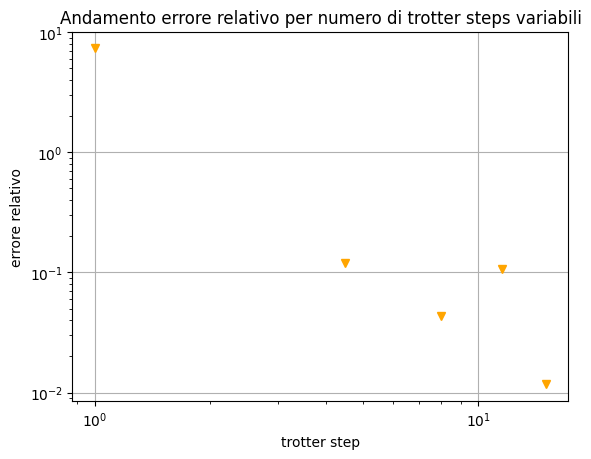

In [11]:
plt.plot(trott_space, value_fixedtime,'v', color="orange", )

plt.xlabel('trotter step')
plt.ylabel(r'errore relativo')
plt.title(r'Andamento errore relativo per numero di trotter steps variabili')
plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.savefig('../../png/errors/trotter_steps.png')
plt.show()

# FACCIAMO VARIARE IL TEMPO TENENDO FISSO A 12 IL NUMERO DI TROTTER STEPS


In [60]:
t_space = np.linspace(0.1, np.pi, 10)

In [61]:
value_fixedtrotter = []
#time_pm = generate_preset_pass_manager(optimization_level=0)

for t in t_space:
    qc = QuantumCircuit(3)
    #buildiamo lo stato "110"
    qc.x(1)
    qc.x(2)
        
    trott_steps = Heisenberg_Trotter(num_spins=3,trotter_steps=12,t=t)
    qc = qc.compose(trott_steps)
    
    exact_estimator = StatevectorEstimator()
    trotter_result = exact_estimator.run([(qc, prj)]).result()
    trotter_value = trotter_result[0].data.evs
    approx_value = trotter_value.mean().real

    exact_value = [np.abs((initial_state @ U_Heis(3,float(t)) @ initial_state))**2]
    delta = np.abs(exact_value - approx_value)
    value_fixedtrotter.append(delta)

    print(str(t) + " completato" )
    
print("tempo variabile a 12 step completato")

0.1 completato
0.43795473928775475 completato
0.7759094785755095 completato
1.1138642178632643 completato
1.4518189571510192 completato
1.789773696438774 completato
2.1277284357265285 completato
2.4656831750142834 completato
2.8036379143020382 completato
3.141592653589793 completato
tempo variabile a 12 step completato


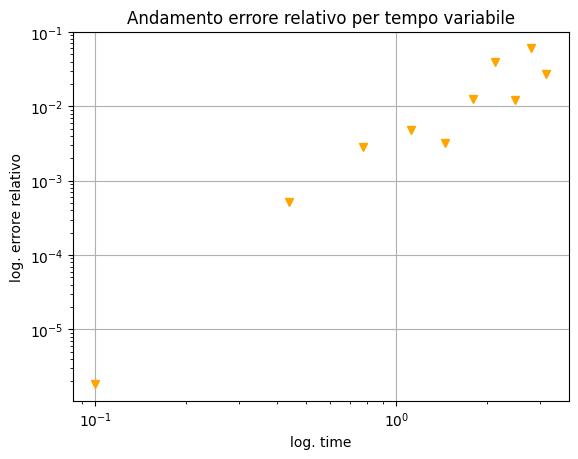

In [62]:
plt.plot(t_space, value_fixedtrotter,'v', color="orange", )

plt.xlabel('log. time')
plt.xscale("log")
plt.yscale("log")
plt.ylabel(r'log. errore relativo')
plt.title(r'Andamento errore relativo per tempo variabile')

plt.grid()
plt.savefig('../../png/errors/time.png')
plt.show()